In [96]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import Matrix, symbols, atan2, pi, exp, sin, cos, sqrt, lambdify, pprint, simplify
from numpy import array, arange
import scienceplots

np.set_printoptions(precision=3, suppress=True)

plt.style.use([
    'grid',
    'retro'
])

In [97]:
m_v = 1500
J_v = 2400
m_d = 100
m_t = 100

M = np.diag([m_v, J_v, m_d, m_t])

c_sd = 500
c_st = 500

l_d  = 1.17
l_t  = 1.68

C = array([
    [c_sd+c_st, l_d*c_sd-l_t*c_st, -c_sd, -c_st],
    [l_d*c_sd-l_t*c_st, l_d**2*c_sd+l_t**2*c_st, -l_d*c_sd, l_t*c_st],
    [-c_sd, -l_d*c_sd, c_sd, 0],
    [-c_st, l_t*c_st, 0, c_st]
])

k_sd = 30000
k_st = 30000
kd   = 300000
kt   = 300000

K = array([
    [k_sd+k_st, l_d*k_sd-l_t*k_st, -k_sd, -k_st],
    [l_d*k_sd-l_t*k_st, l_d**2*k_sd+l_t**2*k_st, -l_d*k_sd, l_t*k_st],
    [-k_sd, -l_d*k_sd, k_sd+kd, 0],
    [-k_st, l_t*k_st, 0, k_st+kt]
])

X0 = array([
    [1],
    [0],
    [1],
    [0],
])

V0 = array([
    [0],
    [-1],
    [0],
    [.5],
])

N = M.shape[0]

In [98]:
# Calculando M á menos meio
M_minus_half = np.vectorize(lambda x: 1/np.sqrt(x) if x != 0 else 0)(M)
M_half       = np.vectorize(lambda x: np.sqrt(x))(M)


# Calculando Ktil
K_til = M_minus_half @ K @ M_minus_half
C_til = M_minus_half @ C @ M_minus_half

wn, P = np.linalg.eig(K_til)
wn    = np.sqrt(wn)

S     = M_minus_half @ P
S_inv = P.T@M_half

Y     = P.T@C_til@P
Y     = Y / (2*wn)
zetas = array([Y[i,i] for i in range(N)])

wds   = wn * np.sqrt(1-zetas**2)
wds   = np.real(wds)

In [99]:
print('wn: ', wn)
print('wd: ', wds)
print('zeta: ', zetas)
print(' ')
print('P: \n', P)
print(' ')
print('S: \n', S)
print(' ')
print('S_inv: \n', S_inv)

wn:  [ 5.72   7.153 57.474 57.491]
wd:  [ 5.715  7.142 57.418 57.433]
zeta:  [0.043 0.054 0.044 0.045]
 
P: 
 [[ 0.897  0.442 -0.029 -0.018]
 [ 0.442 -0.896 -0.014  0.036]
 [ 0.031 -0.009  0.972 -0.231]
 [ 0.007  0.039  0.231  0.972]]
 
S: 
 [[ 0.023  0.011 -0.001 -0.   ]
 [ 0.009 -0.018 -0.     0.001]
 [ 0.003 -0.001  0.097 -0.023]
 [ 0.001  0.004  0.023  0.097]]
 
S_inv: 
 [[ 34.724  21.643   0.309   0.073]
 [ 17.105 -43.909  -0.092   0.389]
 [ -1.105  -0.689   9.725   2.308]
 [ -0.685   1.757  -2.308   9.722]]


In [100]:
# condições iniciais inversas modais
r_0     = (S_inv@X0)
r_dot_0 = (S_inv@V0)

pprint(r_0)
print(' ')
pprint(r_dot_0)

[[35.033] 
 [17.013] 
 [ 8.62 ] 
 [-2.992]]
 
 [[-21.606]
  [ 44.104]
  [  1.843]
 [  3.103]]


In [101]:
# Calculando as soluções modais desacopladas
t = symbols('t')

r = []

forced_response_forces = array([
    [.0],
    [.0],
    [kd],
    [kt]
])

B = np.eye(N)

F = P.T @ M_minus_half @ B @ forced_response_forces
wf = 10

for i in range(N):
    w    = wn[i]
    wd   = wds[i]
    zeta = zetas[i]
    
    r_zero    = r_0    [i, 0]
    rdot_zero = r_dot_0[i, 0]

    Ai = sqrt(
        ( (r_zero * wd)**2 + (rdot_zero + zeta*w*r_zero)**2 ) / (wd**2)
    )

    phi_i = atan2(
        (r_zero*wd),(rdot_zero + zeta*w*r_zero)
    )

    if rdot_zero == 0:
        phi_i = pi/2
    
    expr_r = Ai*exp(-zeta*w*t)*sin(wd*t + phi_i)

    f0 = F[i]
    A0 = f0 / sqrt( (w**2 - wf**2)**2 + (2*zeta*w*wf)**2 )

    theta = atan2( (2*zeta*w*wf), (w**2 - wf**2) )

    if (w**2 - wf**2) == 0:
        theta = pi/2
        
    expr_r += A0*cos(wf*t - theta)
    
    r.append(
        expr_r
    )

R = Matrix(r)
x_t = S@R

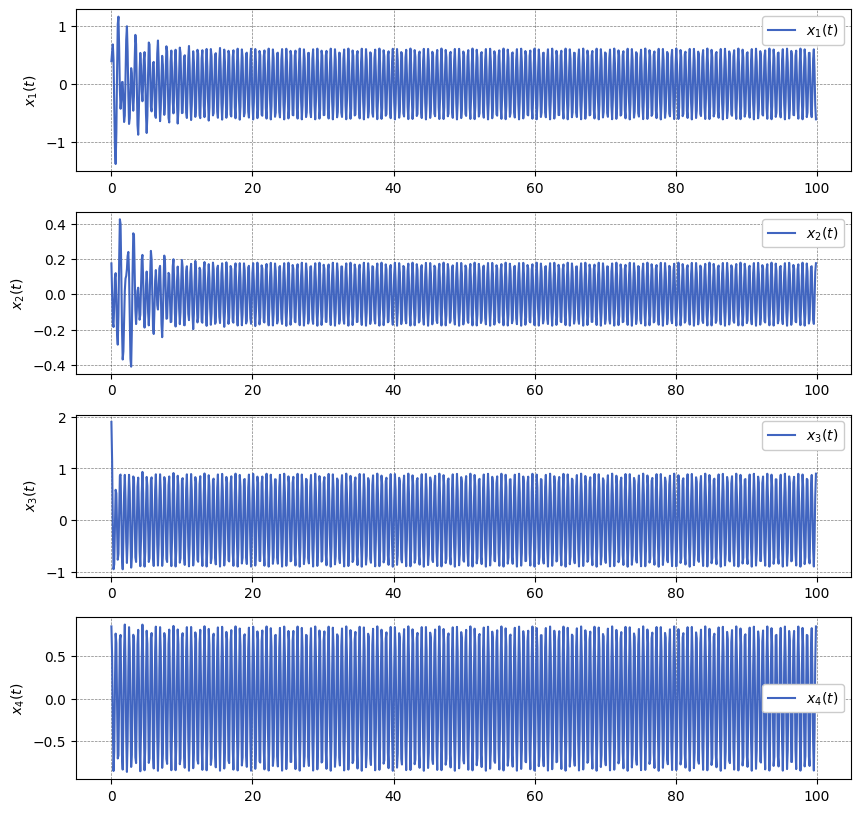

In [102]:
# Simulação

sampling_period = 1e-1
samples = 10000

time = arange(0, samples*sampling_period, sampling_period)

x = [lambdify(t, x_t[i,0], 'numpy') for i in range(N)]

xi = [x[i](time) for i in range(N)]

fig, ax = plt.subplots(N, 1, figsize=(10, 10))
plt.subplots_adjust(hspace=0.25)

idx = 1000

for i in range(N):
    ax[i].plot(time[:idx], xi[i][:idx], label=f'$x_{i+1}(t)$')
    ax[i].set_ylabel(f'$x_{i+1}(t)$')
    ax[i].legend()

plt.savefig('imagens/forced_response.png', dpi=300)

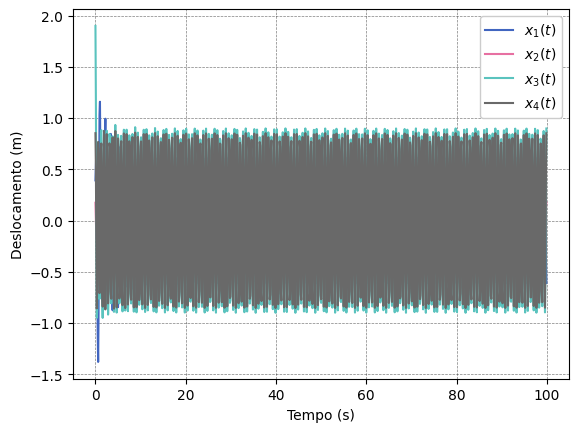

In [103]:
plt.figure()

for i in range(N):
    plt.plot(time[:idx], xi[i][:idx], label=f'$x_{i+1}(t)$')

plt.xlabel('Tempo (s)')
plt.ylabel('Deslocamento (m)')

plt.legend()

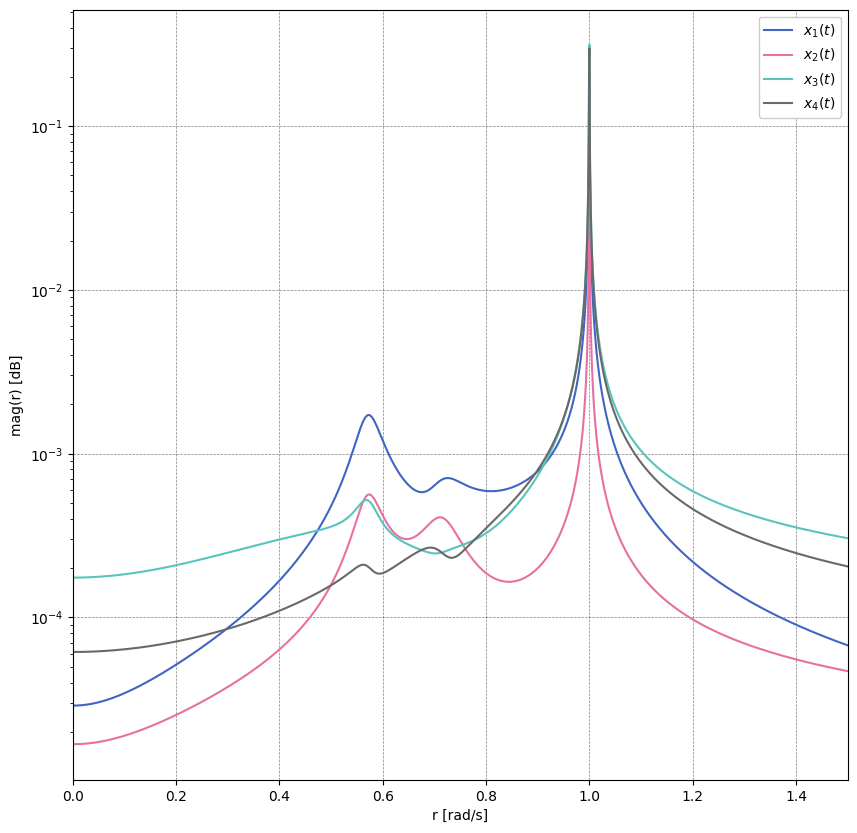

In [104]:
def fft(signal, sampling_time):
    fft = np.fft.fft(signal)
    N = signal.shape[0]

    f = np.fft.fftfreq(len(signal), sampling_time)

    K = N // 2

    freqs = f[:K]*2*np.pi
    amplitudes = np.abs(fft)[:K] * (1 / N)

    phase = np.rad2deg(np.angle(fft)[:K])

    return freqs, amplitudes, phase


ffts   = [fft(xi[i], sampling_period) for i in range(N)]

maximum_amp = np.max([
    np.max(ffts[i][1]) for i in range(N)
])

maximum_freq = np.max(
    [ffts[i][0][np.argmax(ffts[i][1])] for i in range(N)]
)

plt.figure(figsize=(10, 10))
plt.semilogy()

for i in range(N):

    plt.plot(
        ffts[i][0]/maximum_freq,
        ffts[i][1],
        label=f'$x_{i+1}(t)$'
    )

plt.xlim(.0, 1.5)
plt.xlabel('r')
plt.ylabel('mag(r) [dB]')
plt.legend()